# Preprocessing with tensorflow pipelines

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data/autos.csv', encoding='cp1252', index_col=None)

In [8]:
train, test = train_test_split(data, test_size=0.3, random_state=666)
train, val = train_test_split(train, test_size=0.2, random_state=666)

# drop Price outlier
price_desc = train.price.describe()
max_price_outlier = (train.price.quantile(.75) - train.price.quantile(.25))*5 + train.price.quantile(.75)
print('price outlier limit: ' + str(max_price_outlier))
train = train.loc[(train.price < max_price_outlier) & (train.price > 500),]
val = val.loc[(val.price < max_price_outlier) & (val.price > 500),]
# filter year
train = train.loc[(train.yearOfRegistration >= 1864) & (train.yearOfRegistration <= 2017)]
val = val.loc[(val.yearOfRegistration >= 1864) & (val.yearOfRegistration <= 2017)]

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# save data
train.to_csv('data/train.csv', sep=',', index=False)
val.to_csv('data/val.csv', sep=',', index=False)
test.to_csv('data/test.csv', sep=',', index=False)

price outlier limit: 36850.0


In [80]:
# fill NAs

## model, vehicleType, fuelType NAs with "NA"
train.model = train.model.fillna('_NA')
train.vehicleType = train.vehicleType.fillna('_NA')
train.fuelType = train.fuelType.fillna('_NA')

## fill notRepairedDamage NAs with 'nein'
train.notRepairedDamage = train.notRepairedDamage.fillna('nein')

## fill gearbox NAs with most frequent gearbox for model-brand
gearbox_na = train.copy()\
    .loc[train.gearbox.isna() != True,['gearbox','model','brand']]\
    .groupby(['model','brand'], as_index=False)\
    .agg(lambda x:x.value_counts().index[0])
## fill powerps NAs with mean power for model-brand
powerPS_na = train.copy()\
    .loc[train.powerPS > 0,['powerPS','model','brand']]\
    .groupby(['model','brand'], as_index=False)\
    .mean()

gearbox_powerps_na = pd.merge(gearbox_na, powerPS_na, on=['model','brand'], how='outer')

## Save na_encoding
gearbox_powerps_na.to_csv('data/gearbox_powerps_na.csv', sep=',', index=False)

train = pd.merge(train, gearbox_powerps_na, on=['model','brand'], suffixes = ('','_na'), how='left')

train.loc[train.gearbox.isna(),'gearbox'] = train.loc[train.gearbox.isna(),'gearbox_na']
train.loc[train.powerPS.isna(),'powerPS'] = train.loc[train.powerPS.isna(),'powerPS_na']

## case when for a model-brand there is no info of any gearbox
train.loc[train.gearbox.isna(),'gearbox'] = train.gearbox.mode().values

## case when for a model-brand there is no info of any powerPS
train.loc[train.powerPS.isna(),'powerPS'] = train.powerPS.mean()

train = train.drop(['gearbox_na', 'powerPS_na'], axis=1)

In [81]:
# check NA
train.isna().sum()

dateCrawled            0
name                   0
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
dtype: int64

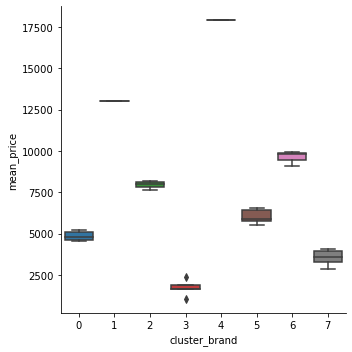

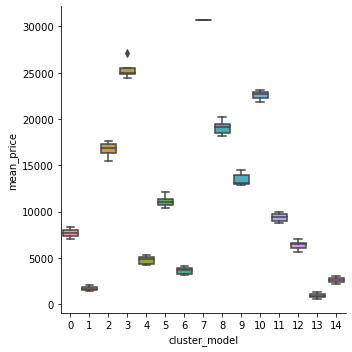

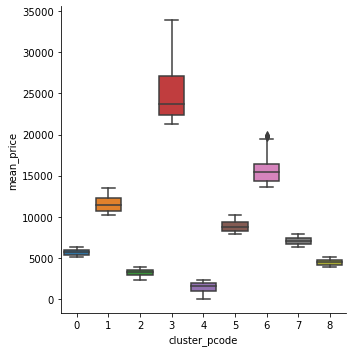

In [124]:
# Clustering categorical features
## Brand
brand_price_train = train.copy().loc[:,['brand','price']]
brand_price_train = brand_price_train.groupby(['brand']).mean()

brand_clustering = KMeans(n_clusters=8, random_state=666)
brand_clustering.fit(np.expand_dims(brand_price_train.price.values, axis=1))
brands_clustered = brand_clustering.predict(np.expand_dims(brand_price_train.price.values, axis=1))

brand_clusters = pd.DataFrame({'brand': brand_price_train.index.values, 'cluster_brand': brands_clustered, 'mean_price': brand_price_train.loc[:,'price']}).reset_index(drop=True)

sns.catplot(x='cluster_brand', y='mean_price', kind="box", data=brand_clusters)
plt.show()

###########
brand_clusters.loc[:,['cluster_brand', 'brand']].to_csv('data/brand_clusters.csv', sep=',', index=False)
###########


## Model
model_price_train = train.copy().loc[:,['model','price']]
model_price_train = model_price_train.groupby(['model']).mean()

model_clustering = KMeans(n_clusters=15, random_state=666)
model_clustering.fit(np.expand_dims(model_price_train.price.values, axis=1))
models_clustered = model_clustering.predict(np.expand_dims(model_price_train.price.values, axis=1))

model_clusters = pd.DataFrame({'model': model_price_train.index.values, 'cluster_model': models_clustered, 'mean_price': model_price_train.loc[:,'price']}).reset_index(drop=True)

sns.catplot(x='cluster_model', y='mean_price', kind="box", data=model_clusters)
plt.show()

###########
model_clusters.loc[:,['cluster_model', 'model']].to_csv('data/model_clusters.csv', sep=',', index=False)
###########


## Postal code
postalcode_price_train = train.copy().loc[:,['postalCode','price']]
postalcode_price_train = postalcode_price_train.groupby(['postalCode']).mean()

postalcode_clustering = KMeans(n_clusters=9, random_state=666)
postalcode_clustering.fit(np.expand_dims(postalcode_price_train.price.values, axis=1))
postalcode_clustered = postalcode_clustering.predict(np.expand_dims(postalcode_price_train.price.values, axis=1))

postalcode_clusters = pd.DataFrame({'postalCode': postalcode_price_train.index.values, 'cluster_pcode': postalcode_clustered, 'mean_price': postalcode_price_train.loc[:,'price']}).reset_index(drop=True)


sns.catplot(x='cluster_pcode', y='mean_price', kind="box", data=postalcode_clusters)
plt.show()

###########
postalcode_clusters.loc[:,['cluster_pcode', 'postalCode']].to_csv('data/postalcode_clusters.csv', sep=',', index=False)
###########

In [120]:
a = pd.DataFrame({'b':[1,2,3,4,float('NaN')]})

a.loc[a.b.isna(),'b'] = 4

a

,b
0,1.0
1,2.0
2,3.0
3,4.0
4,4.0


In [11]:
# Transform yearOfRegistration feature
## Data is from 2017
train.yearOfRegistration = 2017 - train.yearOfRegistration

In [12]:
# Normalize numerical features
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer']

numerical_features_normalization = pd.DataFrame({
    'feature': numerical_features,
    'mean': [np.mean(train[x]) for x in numerical_features],
    'std': [np.std(train[x]) for x in numerical_features]
})

numerical_features_normalization

# save normalization parameters
numerical_features_normalization.to_csv('data/numerical_features_normalization.csv', sep=",", index=False)

In [297]:
numerical_features_normalization

,feature,mean,std
0,yearOfRegistration,13.822326,7.665979
1,powerPS,115.608013,190.277829
2,kilometer,125670.457330,40040.277549
